In [69]:
import detectron2
import os
import shutil
import torch
import cv2
import random
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.evaluation import COCOEvaluator
from detectron2.data import DatasetCatalog, MetadataCatalog, DatasetMapper
from detectron2.data import transforms as T
from detectron2.data.datasets import register_coco_instances
from detectron2.data import build_detection_train_loader
from matplotlib import pyplot as plt

%matplotlib inline
setup_logger()

<Logger detectron2 (DEBUG)>

In [70]:
os.makedirs("images", exist_ok=True)
if  len(os.listdir("images")) == 0:
    !curl -L "https://universe.roboflow.com/ds/4tQNhO3ScX?key=vzphVaMKf7" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip;
    shutil.move("test", "images/test")
    shutil.move("train", "images/train")
    shutil.move("valid", "images/valid")

In [71]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device.type)
!nvcc --version

Using PyTorch version: 2.6.0  Device: cuda
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Wed_Jan_15_19:20:09_PST_2025
Cuda compilation tools, release 12.8, V12.8.61
Build cuda_12.8.r12.8/compiler.35404655_0


In [72]:
register_coco_instances("trashnet_train", {}, "images/train/_annotations.coco.json", "images/train")
register_coco_instances("trashnet_test", {}, "images/test/_annotations.coco.json", "images/test")
register_coco_instances("trashnet_valid", {}, "images/valid/_annotations.coco.json", "images/valid")

In [73]:
train_meta = MetadataCatalog.get("trashnet_train")
train_dict = DatasetCatalog.get("trashnet_train")

WARNING [05/06 21:03:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/06 21:03:59 d2.data.datasets.coco]: Loaded 1757 images in COCO format from images/train/_annotations.coco.json


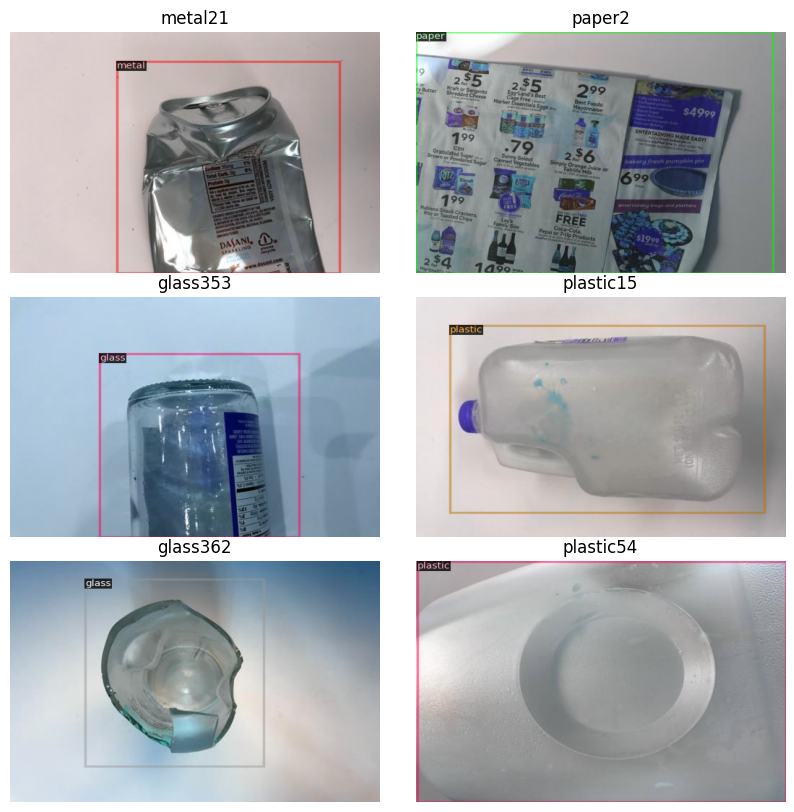

In [74]:
objects = random.sample(train_dict, 6)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
i = 0
for obj in objects:
    img = cv2.imread(obj["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_meta)
    vis = visualizer.draw_dataset_dict(obj)

    row = i // 2
    col = i % 2
    axes[row, col].axis("off")
    axes[row, col].imshow(vis.get_image()[:, :, ::-1], aspect="auto")
    axes[row, col].set_title(obj["file_name"].split("_jpg")[0].split("/")[-1])
    i += 1

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [75]:
augs = [
    T.RandomRotation([-15, 15]),
    T.RandomBrightness(0.9, 1.1),
    T.RandomContrast(0.9, 1.1),
    T.RandomSaturation(0.9, 1.1),
    T.RandomLighting(0.1),
    T.RandomFlip(0.5),
    T.RandomFlip(0.5, horizontal=False, vertical=True),
]

class COCOTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)
    @classmethod
    def build_train_loader(cls, cfg):
        dataset_name = cfg.DATASETS.TRAIN[0]
        metadata = MetadataCatalog.get(dataset_name)

        trash_idx = metadata.thing_classes.index("trash")
        dataset_dicts = DatasetCatalog.get(dataset_name)
        filtered_dataset = [] #NO trash label!!
        for d in dataset_dicts:
            new_d = dict(d)
            new_d["annotations"] = [
                anno for anno in d["annotations"]
                if anno["category_id"] != trash_idx
            ]
            if len(new_d["annotations"]) > 0:
                filtered_dataset.append(new_d)
        train_mapper = DatasetMapper(
            cfg,
            is_train=True,
            augmentations=augs
        )
        return build_detection_train_loader(
            cfg,
            mapper=train_mapper,
            dataset=filtered_dataset
        )

labels = train_meta.get("thing_classes", None)
print(labels)

['idk', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [76]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("trashnet_train",)
cfg.DATASETS.TEST = ("trashnet_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 6800
cfg.MODEL.DEVICE = device.type
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(labels)

In [77]:
#ONLY if you want training!
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = COCOTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[05/06 21:04:00 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [78]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("trashnet_test", )
predictor = DefaultPredictor(cfg)

[05/06 21:04:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


WARNING [05/06 21:04:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/06 21:04:49 d2.data.datasets.coco]: Loaded 264 images in COCO format from images/test/_annotations.coco.json


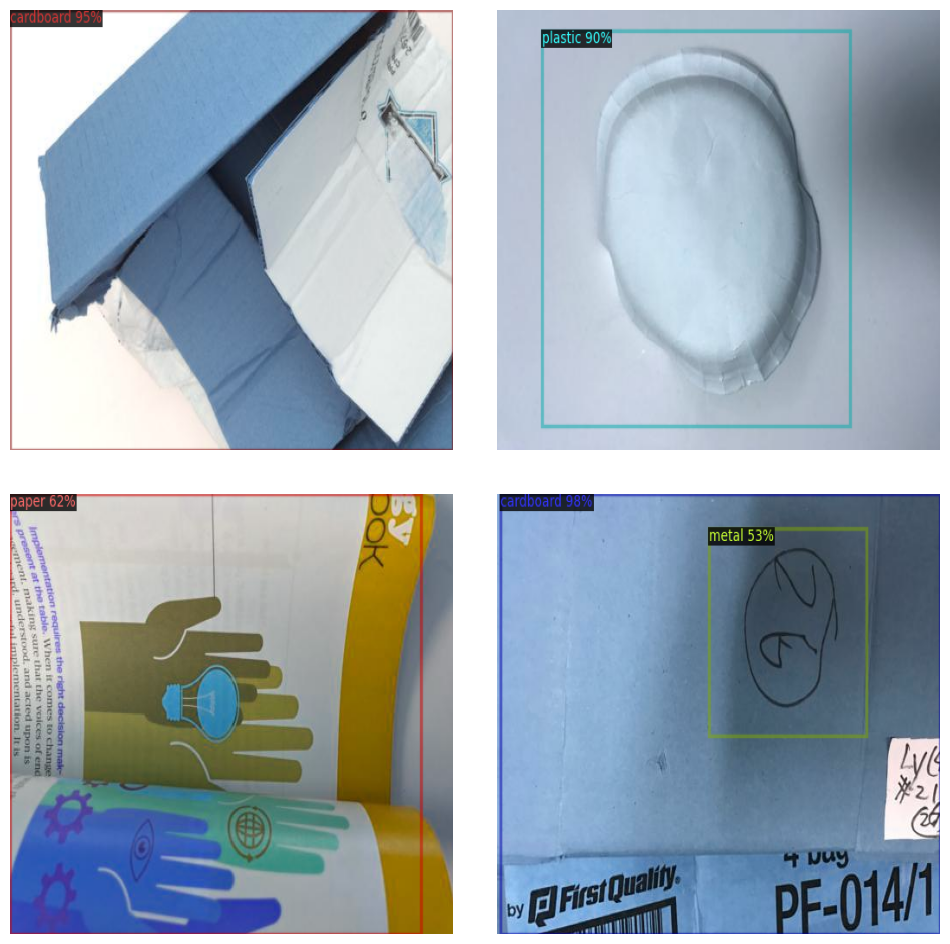

In [79]:
test_metadata = MetadataCatalog.get("trashnet_test")
test_dict = DatasetCatalog.get("trashnet_test")

objects = random.sample(test_dict, 4)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
i = 0

for obj in objects:
    img = cv2.imread(obj["file_name"])
    output = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=test_metadata)
    out = v.draw_instance_predictions(output["instances"].to("cpu"))

    row = i // 2
    col = i % 2
    axes[row, col].axis("off")
    axes[row, col].imshow(out.get_image()[:,:,::-1], aspect="auto")
    i += 1

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [92]:
%load_ext tensorboard
%tensorboard --logdir=output --port=6007

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Instances(num_instances=1, image_height=768, image_width=1024, fields=[pred_boxes: Boxes(tensor([[  39.0357,    0.0000, 1022.6760,  768.0000]])), scores: tensor([0.8688]), pred_classes: tensor([1])])


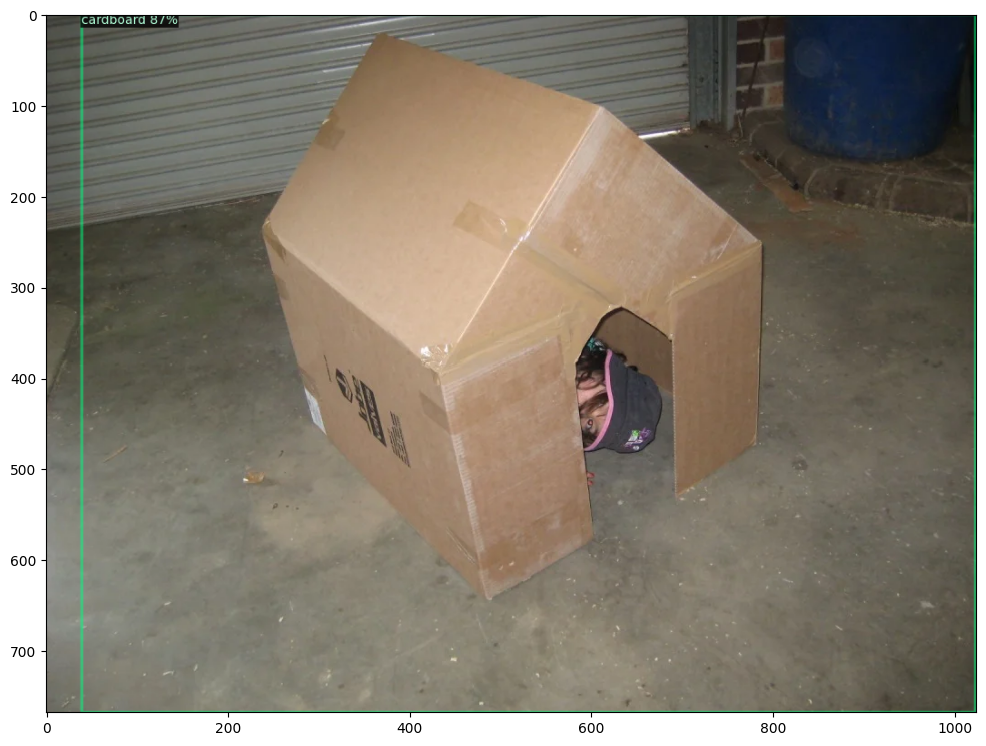

In [81]:
#image outside of the testing set

def take_and_test(image) -> None:
    output=predictor(image)
    print(output["instances"].to("cpu"))
    v = Visualizer(image[:, :, ::-1], metadata=test_metadata)
    print(v)
    v = v.draw_instance_predictions(output["instances"].to("cpu"))
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(v.get_image()[:,:,::-1], cv2.COLOR_BGR2RGB))

test = cv2.imread("custom_test_images/box_house.webp")
take_and_test(test)

Instances(num_instances=2, image_height=360, image_width=643, fields=[pred_boxes: Boxes(tensor([[ 63.4430,  67.8786, 334.2733, 284.6076],
        [297.8347,  47.2262, 571.5410, 292.9113]])), scores: tensor([0.8269, 0.5821]), pred_classes: tensor([3, 5])])


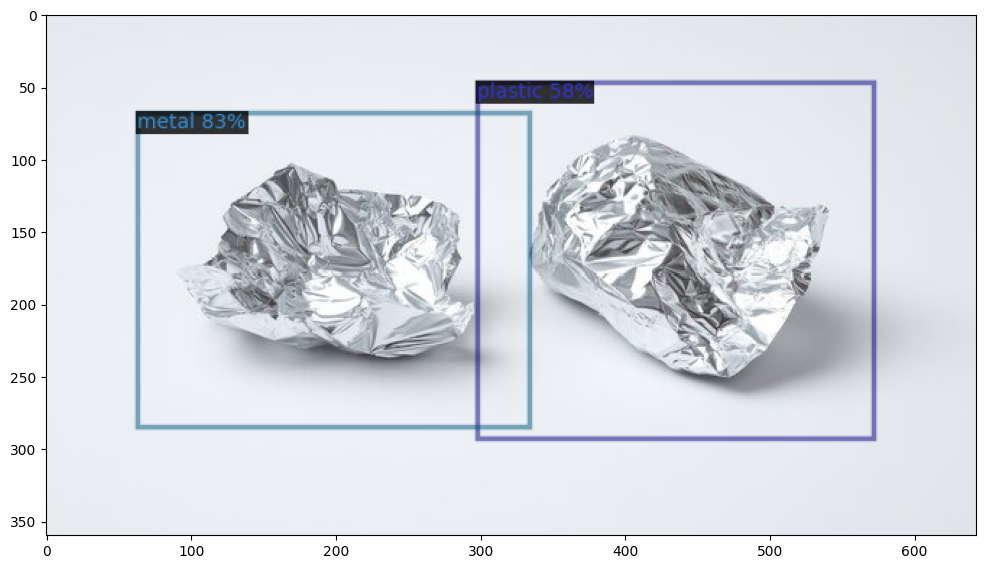

In [82]:
test = cv2.imread("custom_test_images/aluminium_foil.jpg")
take_and_test(test)

Instances(num_instances=5, image_height=900, image_width=1200, fields=[pred_boxes: Boxes(tensor([[   0.0000,   64.9870,  346.6800,  840.6591],
        [   8.3705,   63.7080,  735.1016,  876.7008],
        [ 622.7714,   54.4680, 1193.2006,  868.6450],
        [ 507.2675,   92.3516,  942.3515,  878.7214],
        [ 336.0962,   83.9870,  703.6629,  852.0686]])), scores: tensor([0.9207, 0.9052, 0.8808, 0.7488, 0.5321]), pred_classes: tensor([2, 2, 2, 2, 2])])


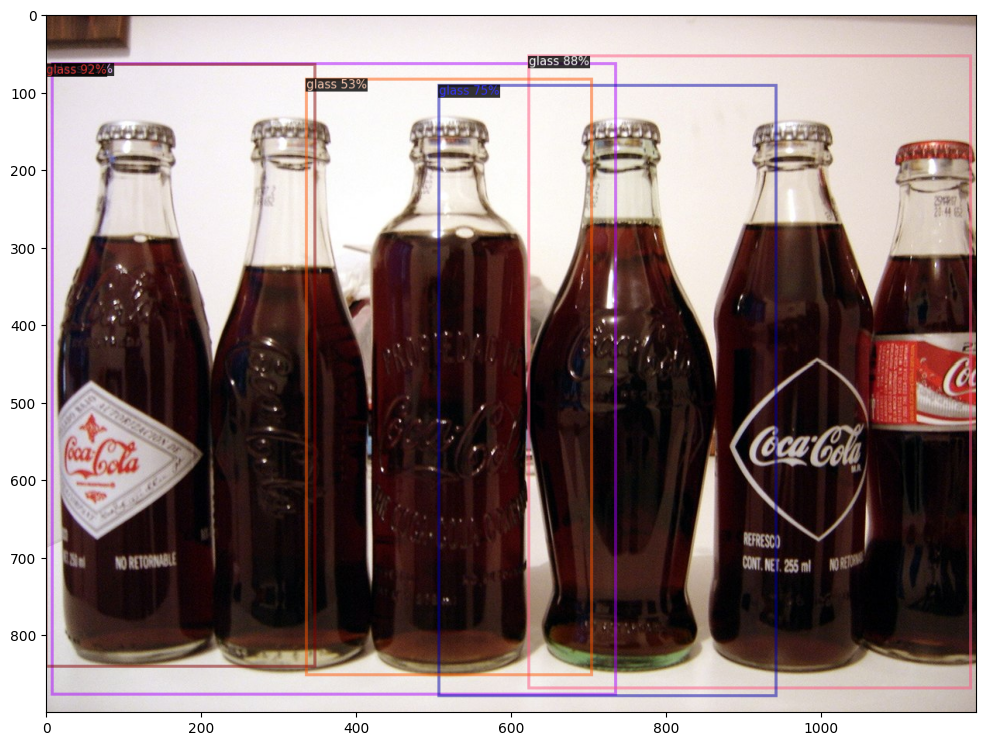

In [83]:
test = cv2.imread("custom_test_images/many_cokes.JPG")
take_and_test(test)

Instances(num_instances=1, image_height=1600, image_width=1200, fields=[pred_boxes: Boxes(tensor([[   0.0000,   72.8301, 1200.0000, 1600.0000]])), scores: tensor([0.6616]), pred_classes: tensor([3])])


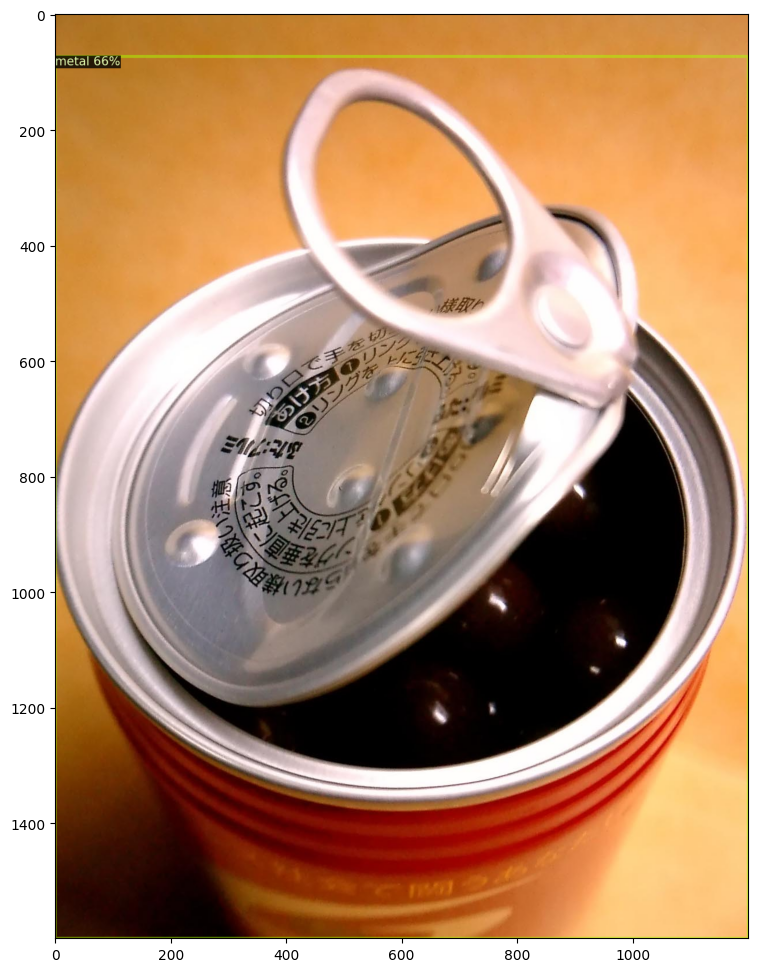

In [90]:
test = cv2.imread("custom_test_images/open_can.JPG")
take_and_test(test)

Instances(num_instances=1, image_height=1436, image_width=1200, fields=[pred_boxes: Boxes(tensor([[ 165.5800,  110.0906, 1032.1055, 1361.2875]])), scores: tensor([0.8674]), pred_classes: tensor([3])])


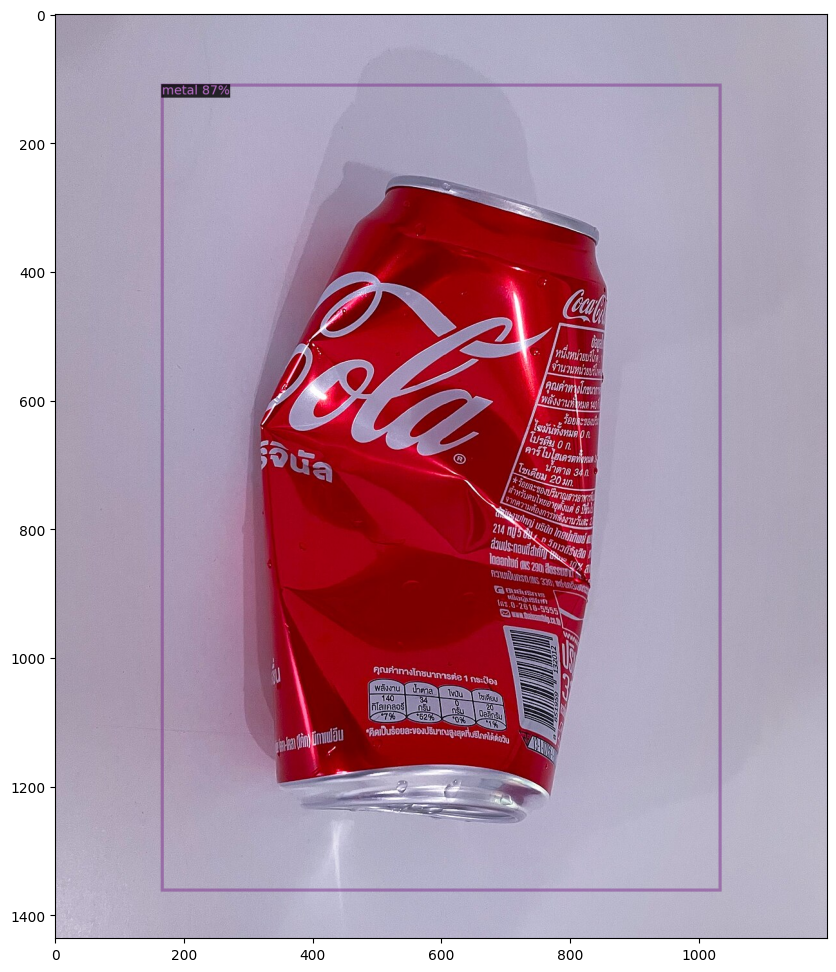

In [85]:
test = cv2.imread("custom_test_images/crushed_can.jpg")
take_and_test(test)

Instances(num_instances=1, image_height=1920, image_width=2880, fields=[pred_boxes: Boxes(tensor([[ 802.5045,  260.4670, 2432.8484, 1792.9070]])), scores: tensor([0.8135]), pred_classes: tensor([5])])


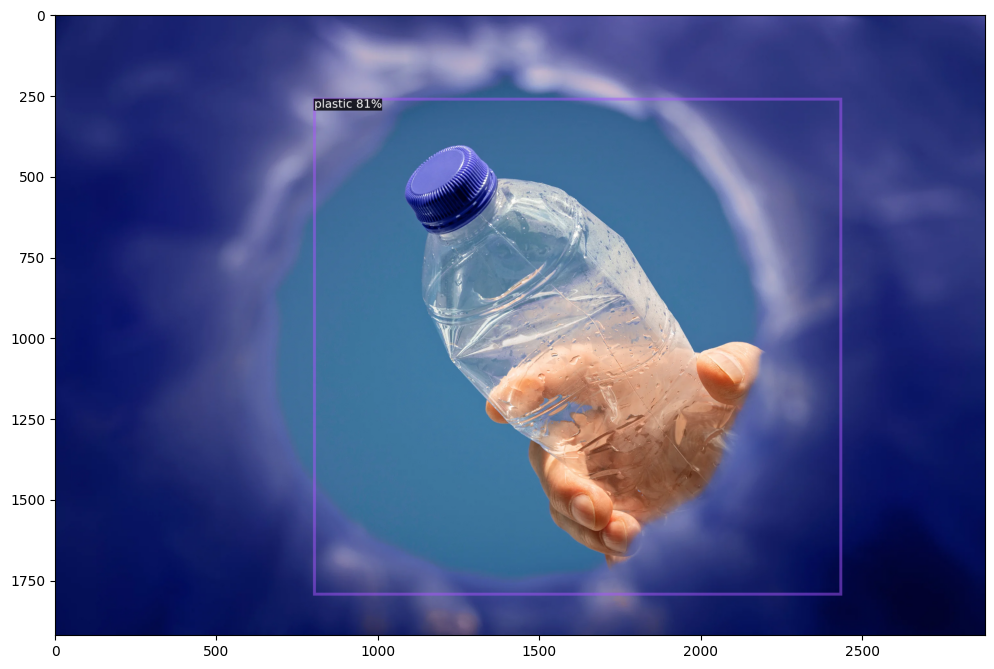

In [86]:
test = cv2.imread("custom_test_images/plastic_bottle2.png")
take_and_test(test)

Instances(num_instances=3, image_height=1200, image_width=900, fields=[pred_boxes: Boxes(tensor([[ 139.4338,   10.8881,  720.0214, 1176.6323],
        [   1.7655,  406.2502,  890.1730, 1194.8046],
        [ 810.3428,  561.3571,  900.0000,  755.8527]])), scores: tensor([0.9032, 0.7303, 0.5305]), pred_classes: tensor([2, 1, 4])])


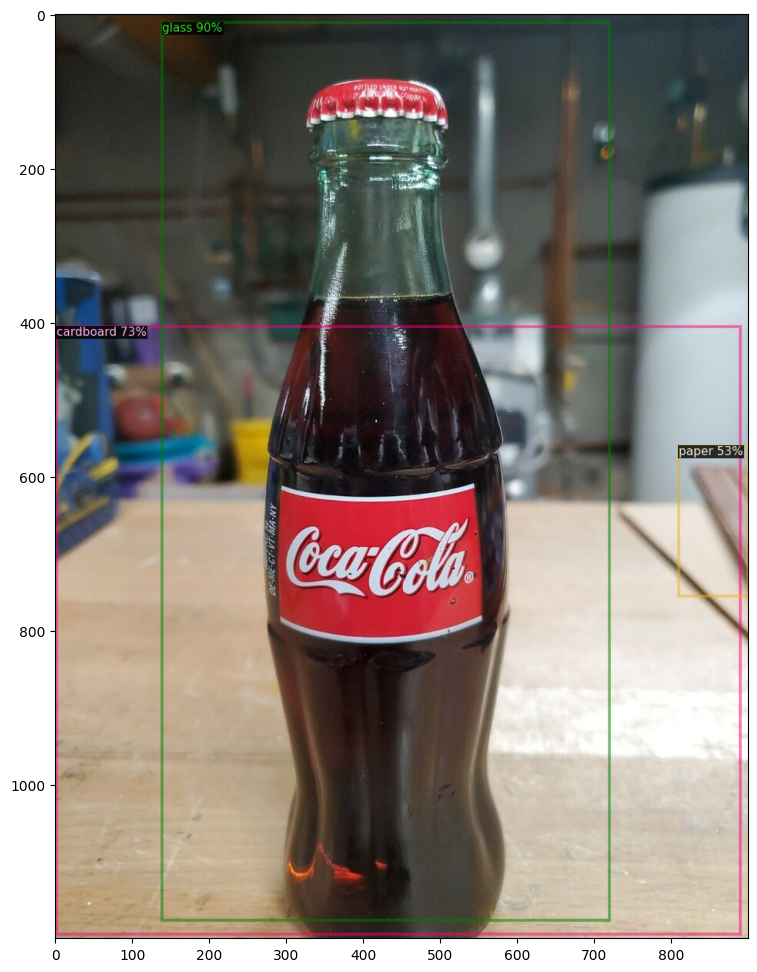

In [87]:
test = cv2.imread("custom_test_images/coke.jpg")
take_and_test(test)

Instances(num_instances=2, image_height=2250, image_width=4000, fields=[pred_boxes: Boxes(tensor([[1083.2673,   97.8344, 3926.7634, 2077.0952],
        [ 601.8066,   41.3439, 2144.3325, 2149.4128]])), scores: tensor([0.6611, 0.6027]), pred_classes: tensor([2, 2])])


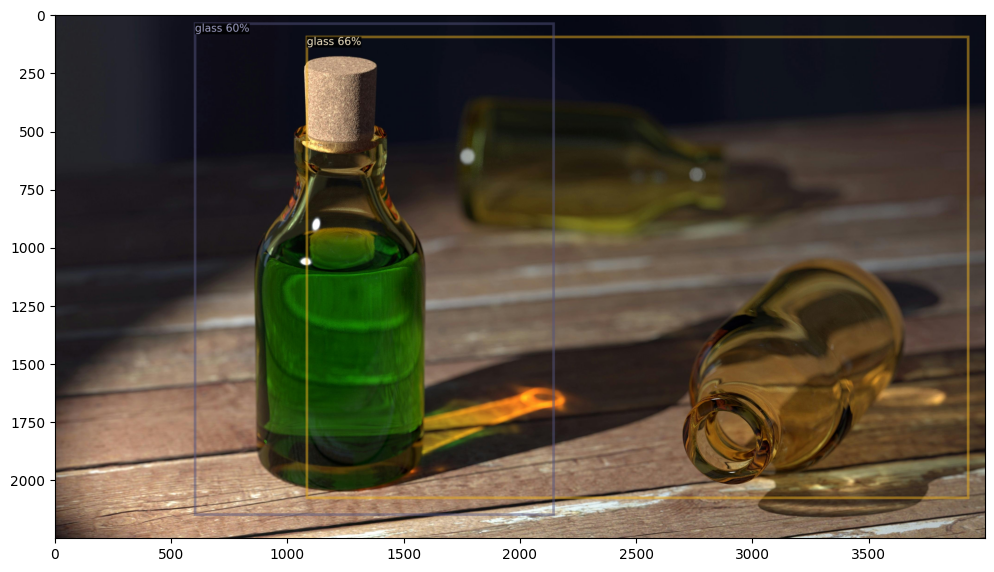

In [88]:
test = cv2.imread("custom_test_images/green.jpeg")
take_and_test(test)

In [89]:
# now save the configs to a file in order to use them on the app!
# .pth files saved the weights, which is most useful! but we need the whole configuration

with open("output/configuration.yaml", "w") as f:
    f.write(cfg.dump())